# Grocery Recommendation Project

1. Data Clustering on users  
2. Recommendation systems
  * Content-based filtering  
  * Collaborative filtering  
3. Metadata NLP Search Engine
3. Market Basket analysis  
4. Website interface  

For this analysis I will be working as a Data Scientist for a grocery store that is looking to discover insights from sales data that could be used for targeted direct mail marketing (specific coupons mailed to customers), targeted email marketing ("An item you like has gone on sale!"), and online shopper recommendations to 'add to cart' based on similar items and also based on items other people who bought that item have purchased.  

If time permits, I may also perform a market basket analysis to forecast what products a customer is likely to purchase in their next order.

## Dataset information

This data was retrieved from Kaggle and was provided by Instacart for a market basket analysis competition in 2018.  

The data is divided into 6 files:

- **_Aisles.csv_**: 134 Unique aisle numbers and descriptions
- **_Departments.csv_**: 21 Unique department numbers and descriptions
- **_Products.csv_**: 49,688 Unique product ids, with description, aisle id, and department id
- **_Orders.csv_**: 3,421,083 Unique order id, with user id, order number, order_dow, order_hour_of_day, days_since_prior_order, and eval_set indicating if the order is in train, prior, or test
- **_Order_products_train.csv_**: Order id, product id, add to cart order, and reorder indicator
- **_Order_products_prior.csv_**: Order id, product id, add to cart order, and reorder indicator


## Exploratory Data Analysis

### Import and basic info

**Output** - aisles, orders, products, departments, order_products_prior, order_products_train

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import time
from user_functions import *
from datetime import datetime
import pickle
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Set default visualization parameters

CB91_Blue = '#2CBDFE'
CB91_Green = '#47DBCD'
CB91_Pink = '#F3A0F2'
CB91_Purple = '#9D2EC5'
CB91_Violet = '#661D98'
CB91_Amber = '#F5B14C'
color_list = [CB91_Blue, CB91_Pink, CB91_Green, CB91_Amber, CB91_Purple, CB91_Violet]
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=color_list)
sns.set_context("notebook", rc={"font.size":16, "axes.titlesize":20, "axes.labelsize":18})
sns.set(font='Franklin Gothic Book',
rc={'axes.axisbelow': False,
'axes.edgecolor': 'lightgrey',
# 'axes.edgecolor': 'white',
'axes.facecolor': 'None',
'axes.grid': False,
'axes.labelcolor': 'dimgrey',
# 'axes.labelcolor': 'white',
'axes.spines.right': False,
'axes.spines.top': False,
'axes.prop_cycle': plt.cycler(color=color_list),
'figure.facecolor': 'white',
'lines.solid_capstyle': 'round',
'patch.edgecolor': 'w',
'patch.force_edgecolor': True,
'text.color': 'dimgrey',
# 'text.color': 'white',    
'xtick.bottom': False,
'xtick.color': 'dimgrey',
# 'xtick.color': 'white',    
'xtick.direction': 'out',
'xtick.top': False,
'ytick.color': 'dimgrey',
# 'ytick.color': 'white',
'ytick.direction': 'out',
'ytick.left': False,
'ytick.right': False})
%matplotlib inline

# NOTE: if you visualizations are too cluttered to read, try calling 'plt.gcf().autofmt_xdate()'!

In [3]:
aisles = pd.read_csv("Data/aisles.csv")
departments = pd.read_csv("Data/departments.csv")
order_products_prior = pd.read_csv("Data/order_products__prior.csv")
order_products_train = pd.read_csv("Data/order_products__train.csv")
orders = pd.read_csv("Data/orders.csv")
products = pd.read_csv("Data/products.csv")

### Checking for Nan values

Data is very clean. Nan values in orders.days_since_prior_order, but they are valid.

In [4]:
aisles.isna().sum()

aisle_id    0
aisle       0
dtype: int64

In [5]:
departments.isna().sum()

department_id    0
department       0
dtype: int64

In [6]:
products.isna().sum()

product_id       0
product_name     0
aisle_id         0
department_id    0
dtype: int64

In [7]:
orders.isna().sum()

order_id                       0
user_id                        0
eval_set                       0
order_number                   0
order_dow                      0
order_hour_of_day              0
days_since_prior_order    206209
dtype: int64

In [8]:
orders.days_since_prior_order.value_counts()
# Nothing greater than 30 here so it must actually be '30+'

30.0    369323
7.0     320608
6.0     240013
4.0     221696
3.0     217005
5.0     214503
2.0     193206
8.0     181717
1.0     145247
9.0     118188
14.0    100230
10.0     95186
13.0     83214
11.0     80970
12.0     76146
0.0      67755
15.0     66579
16.0     46941
21.0     45470
17.0     39245
20.0     38527
18.0     35881
19.0     34384
22.0     32012
28.0     26777
23.0     23885
27.0     22013
24.0     20712
25.0     19234
29.0     19191
26.0     19016
Name: days_since_prior_order, dtype: int64

In [9]:
orders.head()
# order_id is a unique key for the order
# order_number is specific to a user
# seems like for any user, order 1 will have a Nan in days_since_prior_order since it is their first order

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [10]:
order_products_train.isna().sum()

order_id             0
product_id           0
add_to_cart_order    0
reordered            0
dtype: int64

In [11]:
order_products_prior.isna().sum()

order_id             0
product_id           0
add_to_cart_order    0
reordered            0
dtype: int64

### Analyze 'Products'
  
49688 unique products 

In [12]:
products.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [13]:
print(len(products))
print(products.aisle_id.nunique())
print(products.department_id.nunique())

49688
134
21


In [14]:
# How many products in each department and aisle?
# I guess these would be better/more informative with aisle and dept names
products_aisles = pd.merge(products, aisles, on = 'aisle_id', how = 'left')
products_desc = pd.merge(products_aisles, departments, on = 'department_id', how = 'left')
products_desc.head()

,product_id,product_name,aisle_id,department_id,aisle,department
0,1,Chocolate Sandwich Cookies,61,19,cookies cakes,snacks
1,2,All-Seasons Salt,104,13,spices seasonings,pantry
2,3,Robust Golden Unsweetened Oolong Tea,94,7,tea,beverages
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1,frozen meals,frozen
4,5,Green Chile Anytime Sauce,5,13,marinades meat preparation,pantry


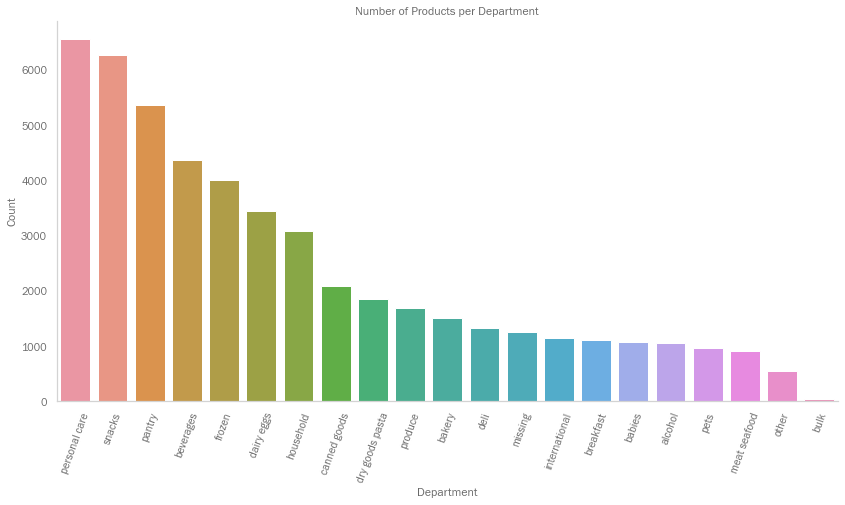

In [15]:
plt.figure(figsize = (14,7))
sns.countplot(x='department', data= products_desc, order = products_desc.department.value_counts().index)
plt.title('Number of Products per Department')
plt.xticks(rotation=70)
plt.ylabel('Count')
plt.xlabel('Department')
plt.savefig('Images/products_by_department.png');

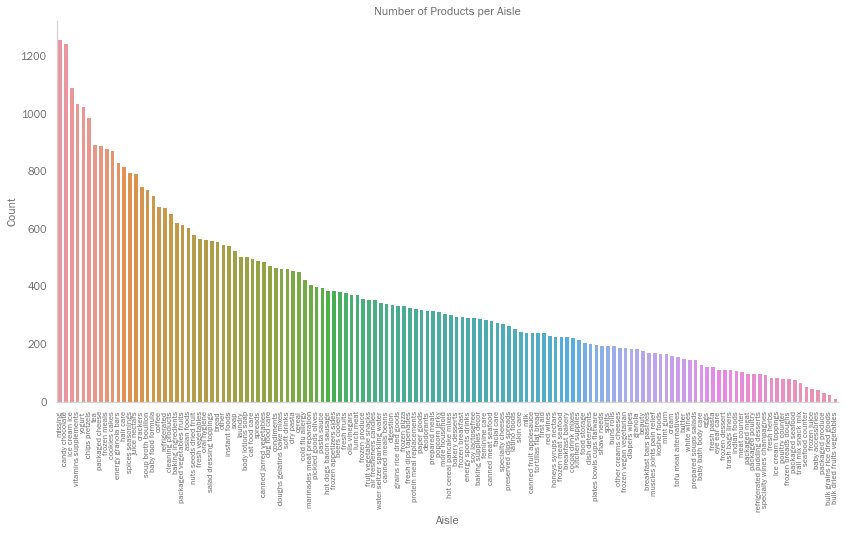

In [16]:
plt.figure(figsize = (14,7))
sns.countplot(x='aisle', data= products_desc, order = products_desc.aisle.value_counts().index)
plt.title('Number of Products per Aisle')
plt.xticks(rotation=90, fontsize = 8)
plt.ylabel('Count')
plt.xlabel('Aisle')
plt.savefig('Images/products_by_aisle.png');
# Uh oh, 'missing' is our most popular aisle
# And I see there is a 'missing' value for department above as well

In [17]:
products_desc[products_desc['aisle']=='missing']
# It appears that 1258 products have 'missing' aisle 100 and department 21

,product_id,product_name,aisle_id,department_id,aisle,department
37,38,Ultra Antibacterial Dish Liquid,100,21,missing,missing
71,72,Organic Honeycrisp Apples,100,21,missing,missing
109,110,Uncured Turkey Bologna,100,21,missing,missing
296,297,"Write Bros Ball Point Pens, Cap-Pen, Medium (1...",100,21,missing,missing
416,417,Classics Baby Binks Easter Chocolate Bunny,100,21,missing,missing
...,...,...,...,...,...,...
49552,49553,Organic Plain Skyr,100,21,missing,missing
49574,49575,Chocolate Vanilla Malt Custard,100,21,missing,missing
49640,49641,"8\"" Pecan Pie",100,21,missing,missing
49663,49664,Lemon Cayenne Drinking Vinegar,100,21,missing,missing


In [18]:
# Just confirming the one to many relationship between department and aisle
products_desc[products_desc['department']=='snacks']

,product_id,product_name,aisle_id,department_id,aisle,department
0,1,Chocolate Sandwich Cookies,61,19,cookies cakes,snacks
15,16,Mint Chocolate Flavored Syrup,103,19,ice cream toppings,snacks
24,25,Salted Caramel Lean Protein & Fiber Bar,3,19,energy granola bars,snacks
31,32,Nacho Cheese White Bean Chips,107,19,chips pretzels,snacks
40,41,Organic Sourdough Einkorn Crackers Rosemary,78,19,crackers,snacks
...,...,...,...,...,...,...
49661,49662,Bacon Cheddar Pretzel Pieces,107,19,chips pretzels,snacks
49664,49665,Super Dark Coconut Ash & Banana Chocolate Bar,45,19,candy chocolate,snacks
49665,49666,Ginger Snaps Snacking Cookies,61,19,cookies cakes,snacks
49670,49671,Milk Chocolate Drops,45,19,candy chocolate,snacks


In [19]:
# An aisle only belongs to one department
products_desc[products_desc['aisle_id']==45]

,product_id,product_name,aisle_id,department_id,aisle,department
123,124,Sun Cups Dark Chocolate,45,19,candy chocolate,snacks
135,136,Simple,45,19,candy chocolate,snacks
183,184,Kisses Milk Chocolate Candy,45,19,candy chocolate,snacks
206,207,Minis Candy Bars,45,19,candy chocolate,snacks
226,227,Triple Chocolate Snack Size,45,19,candy chocolate,snacks
...,...,...,...,...,...,...
49503,49504,Dark Chocolate Peanut Butter Cups Miniatures,45,19,candy chocolate,snacks
49600,49601,Pomegranate Gummy Bears,45,19,candy chocolate,snacks
49619,49620,Milk Chocolate Mini's,45,19,candy chocolate,snacks
49664,49665,Super Dark Coconut Ash & Banana Chocolate Bar,45,19,candy chocolate,snacks


In [20]:
pickle.dump(products_desc, open("Pickle/products_desc.p", "wb"))

### Analyze Orders

In [21]:
print(len(orders))
print(orders.order_id.min())
print(orders.order_id.max())

3421083
1
3421083


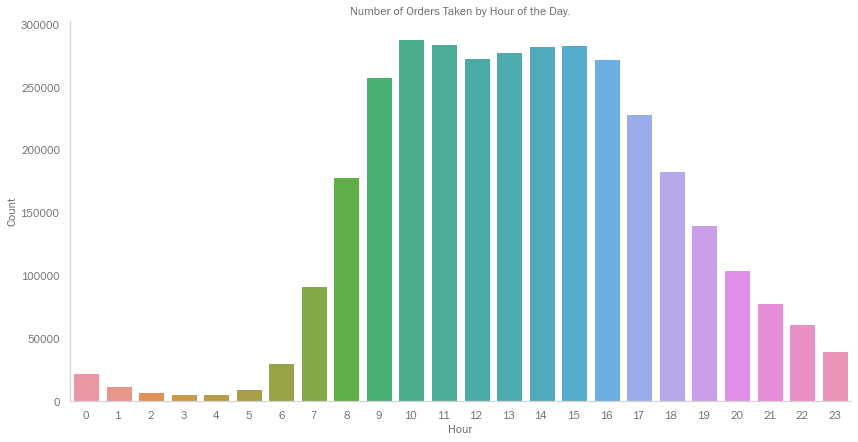

In [22]:
plt.figure(figsize = (14,7))
sns.countplot(x='order_hour_of_day', data= orders)
plt.title('Number of Orders Taken by Hour of the Day.')
plt.ylabel('Count')
plt.xlabel('Hour')
plt.savefig('Images/orders_by_hour.png');

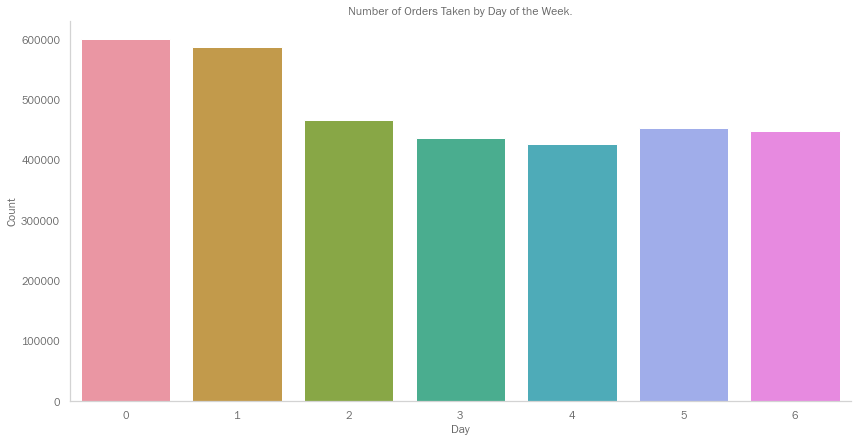

In [23]:
plt.figure(figsize = (14,7))
sns.countplot(x='order_dow', data= orders)
plt.title('Number of Orders Taken by Day of the Week.')
plt.ylabel('Count')
plt.xlabel('Day')
plt.savefig('Images/orders_by_dow.png');

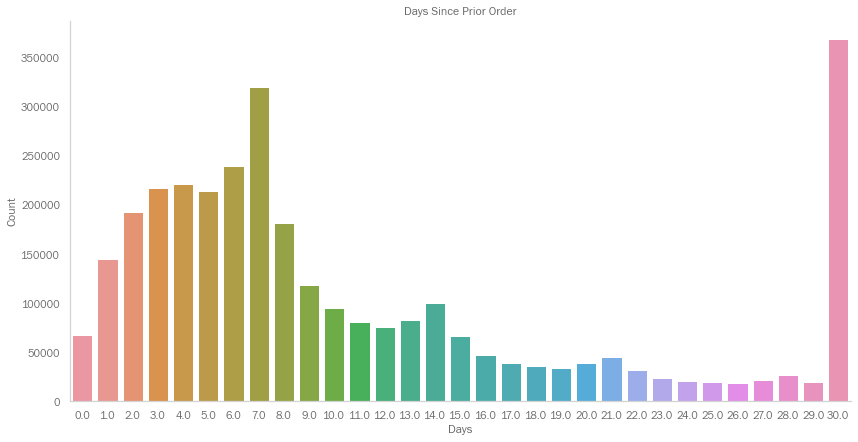

In [24]:
plt.figure(figsize = (14,7))
sns.countplot(x='days_since_prior_order', data= orders)
plt.title('Days Since Prior Order')
plt.ylabel('Count')
plt.xlabel('Days')
plt.savefig('Images/days_since_order.png');

# Spikes at 7, 14, 21, and 28 indicate people who reorder weekly, or every 2 or three weeks but on the same day
# Does 0.0 days mean someone ordered twice in the same day?
# Surprising how many people order more than once a week
# 30 does seem to indicate 30 or more days since last order

In [25]:
orders.head(15)
# Appears to be sorted by user_id and then order_number
# Most recent order_number per user_id is in the train(or test) set, others in prior
# First order per user has NaN in days_since

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0
5,3367565,1,prior,6,2,7,19.0
6,550135,1,prior,7,1,9,20.0
7,3108588,1,prior,8,1,14,14.0
8,2295261,1,prior,9,1,16,0.0
9,2550362,1,prior,10,4,8,30.0


In [26]:
orders.sort_values('order_id') # Just checking that it has all the order_ids starting at 1

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
1868044,1,112108,train,4,4,10,9.0
3355525,2,202279,prior,3,5,9,8.0
3417191,3,205970,prior,16,5,17,12.0
2958007,4,178520,prior,36,1,9,7.0
2593373,5,156122,prior,42,6,16,9.0
...,...,...,...,...,...,...,...
1809968,3421079,108687,prior,6,1,13,0.0
877324,3421080,52726,prior,2,1,11,2.0
1949724,3421081,117076,prior,1,3,11,NaN
2903252,3421082,175185,prior,23,2,18,4.0


In [27]:
orders_test = orders[orders['eval_set']=='test'] # 75000 orders in our test set
# So basically for these test orders, I don't have the answers.  I don't know what products were ordered.
# If I do market basket analysis I will get to these
orders_test

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
38,2774568,3,test,13,5,15,11.0
44,329954,4,test,6,3,12,30.0
53,1528013,6,test,4,3,16,22.0
96,1376945,11,test,8,6,11,8.0
102,1356845,12,test,6,1,20,30.0
...,...,...,...,...,...,...,...
3420918,2728930,206202,test,23,2,17,6.0
3420929,350108,206204,test,5,4,14,14.0
3421001,1043943,206206,test,68,0,20,0.0
3421018,2821651,206207,test,17,2,13,14.0


In [28]:
orders[orders['user_id']==3] # But I have all of this user's order/products in prior

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
26,1374495,3,prior,1,1,14,NaN
27,444309,3,prior,2,3,19,9.0
28,3002854,3,prior,3,3,16,21.0
29,2037211,3,prior,4,2,18,20.0
30,2710558,3,prior,5,0,17,12.0
31,1972919,3,prior,6,0,16,7.0
32,1839752,3,prior,7,0,15,7.0
33,3225766,3,prior,8,0,17,7.0
34,3160850,3,prior,9,0,16,7.0
35,676467,3,prior,10,3,16,17.0


### Analyze Order_products_train and _prior

In [29]:
order_products_train.head()

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


In [30]:
print(len(order_products_train)) # Has 1,384,617 order/products
print(order_products_train.order_id.min()) # starts with order number 1
print(order_products_train.order_id.max())
print(order_products_train.order_id.nunique()) # Has 131,209 unique orders

1384617
1
3421070
131209


In [31]:
order_products_prior.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [32]:
print(len(order_products_prior)) # Has 32,434,489 order/products
print(order_products_prior.order_id.min()) # starts with order number 2
print(order_products_prior.order_id.max())
print(order_products_prior.order_id.nunique()) # Has 3,214,874 unique orders

32434489
2
3421083
3214874


In [33]:
order_products_prior[order_products_prior.order_id == 2]

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0
5,2,17794,6,1
6,2,40141,7,1
7,2,1819,8,1
8,2,43668,9,0


In [34]:
orders[orders.order_id == 2]

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
3355525,2,202279,prior,3,5,9,8.0


In [35]:
orders[orders.user_id == 202279]
# This user's third order was order number 2.  Need to be sure not to think order_id is chronological.

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
3355523,2894949,202279,prior,1,5,9,NaN
3355524,1500071,202279,prior,2,4,13,20.0
3355525,2,202279,prior,3,5,9,8.0
3355526,3058248,202279,prior,4,3,14,30.0
3355527,2808715,202279,prior,5,5,13,9.0
3355528,132412,202279,prior,6,5,9,30.0
3355529,2382766,202279,prior,7,1,14,24.0
3355530,104690,202279,prior,8,6,10,30.0
3355531,1050357,202279,train,9,1,14,30.0


In [36]:
order_products_train[order_products_train.order_id == 1050357]

,order_id,product_id,add_to_cart_order,reordered
429686,1050357,33120,1,1
429687,1050357,1003,2,1
429688,1050357,21543,3,1
429689,1050357,20995,4,1
429690,1050357,46064,5,0
429691,1050357,20168,6,0
429692,1050357,42824,7,1
429693,1050357,4461,8,1
429694,1050357,45002,9,1
429695,1050357,8693,10,0


In [37]:
# So what do I know about this user...

# They have ordered 9 times.
len(orders[orders.user_id == 202279])

9

In [38]:
# They usually order on day 5 (presumably Friday)
orders[orders.user_id == 202279].order_dow.mode()

0    5
dtype: int64

In [39]:
# They average 22.6 days between orders
orders[orders.user_id == 202279].days_since_prior_order.mean()

22.625

In [40]:
# They order around 11:30 am.
orders[orders.user_id == 202279].order_hour_of_day.mean()

11.666666666666666

In [41]:
# These are their order numbers
list(orders[orders.user_id == 202279]['order_id'].values)

[2894949, 1500071, 2, 3058248, 2808715, 132412, 2382766, 104690, 1050357]

In [42]:
# But what products have they ordered... merging tables will help here
order_products_prior[order_products_prior['order_id'].isin(list(orders[orders.user_id == 202279]['order_id'].values))]

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0
...,...,...,...,...
28997578,3058248,27531,4,0
28997579,3058248,2944,5,0
28997580,3058248,38226,6,0
28997581,3058248,35106,7,0


## Data Preprocessing

### Merge order_products together

Output: merged_order_products, order_products_desc

In [43]:
print(len(order_products_train))
print(len(order_products_prior))

1384617
32434489


In [44]:
# The dataframe of all order products should be the length of these two together
len(order_products_train)+len(order_products_prior)

33819106

In [45]:
# These two dataframes shouldn't have any overlap.  I need an outer join to merge them together.
merged_order_products = pd.merge(order_products_train, order_products_prior, how = 'outer')
merged_order_products.head()

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


In [46]:
len(merged_order_products)

33819106

In [47]:
# This has an entry for each ordered product.  If we combine it with aisle and department we can see which products
# are ordered the most.
order_products_desc = pd.merge(merged_order_products, products_desc, on = 'product_id')
order_products_desc.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department
0,1,49302,1,1,Bulgarian Yogurt,120,16,yogurt,dairy eggs
1,816049,49302,7,1,Bulgarian Yogurt,120,16,yogurt,dairy eggs
2,1242203,49302,1,1,Bulgarian Yogurt,120,16,yogurt,dairy eggs
3,1383349,49302,11,1,Bulgarian Yogurt,120,16,yogurt,dairy eggs
4,1787378,49302,8,0,Bulgarian Yogurt,120,16,yogurt,dairy eggs


In [48]:
# Very cool.  People really like their bananas.
order_products_desc['product_name'].value_counts()

Banana                    491291
Bag of Organic Bananas    394930
Organic Strawberries      275577
Organic Baby Spinach      251705
Organic Hass Avocado      220877
                           ...  
Dried Porcini Mushroom         1
Sweetart Jelly Beans           1
Escapes Variety Pack           1
Peachtree Schnapps             1
Brut Prosecco                  1
Name: product_name, Length: 49685, dtype: int64

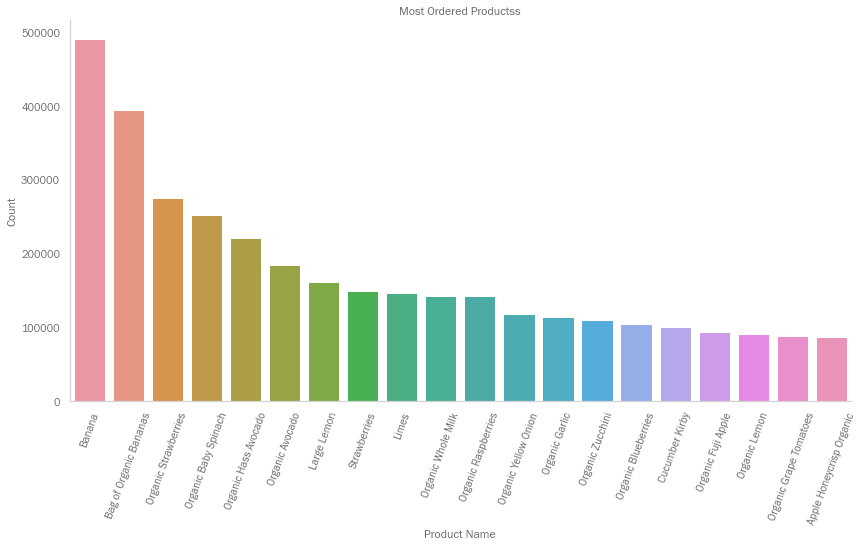

In [49]:
plt.figure(figsize = (14,7))
sns.countplot(x='product_name', data= order_products_desc, 
              order = order_products_desc.product_name.value_counts().index[:20])
plt.title('Most Ordered Productss')
plt.xticks(rotation=70)
plt.ylabel('Count')
plt.xlabel('Product Name')
plt.savefig('Images/ordered_products_by_name.png');

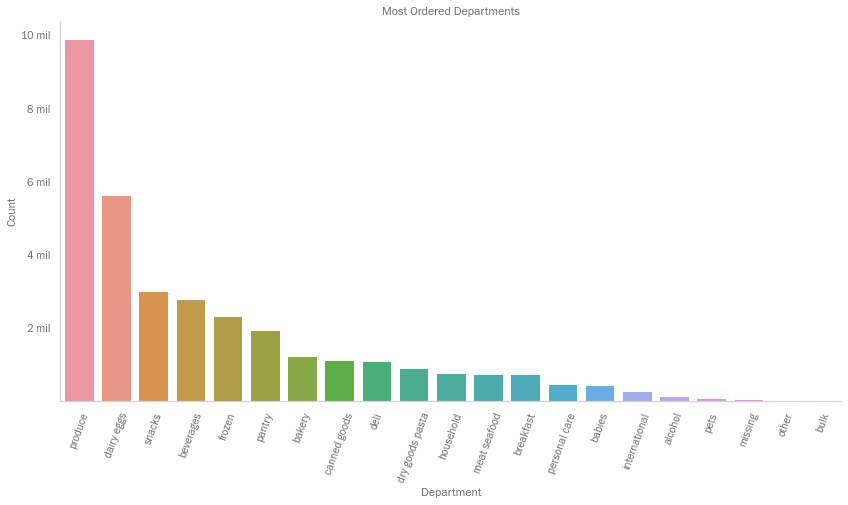

In [50]:
plt.figure(figsize = (14,7))
sns.countplot(x='department', data= order_products_desc, order = order_products_desc.department.value_counts().index)
plt.title('Most Ordered Departments')
plt.xticks(rotation=70)
plt.yticks([2000000,4000000,6000000,8000000,10000000],['2 mil','4 mil','6 mil','8 mil','10 mil'])
plt.ylabel('Count')
plt.xlabel('Department')
plt.savefig('Images/ordered_products_by_department.png');

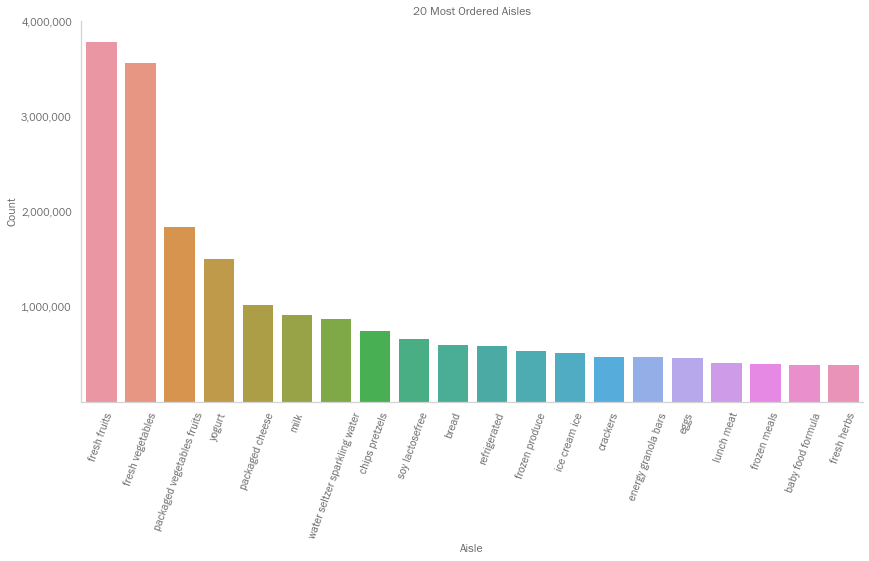

In [51]:
plt.figure(figsize = (14,7))
sns.countplot(x='aisle', data= order_products_desc, order = order_products_desc.aisle.value_counts().index[:20])
plt.title('20 Most Ordered Aisles')
plt.xticks(rotation=70)
plt.yticks([1000000,2000000,3000000,4000000],['1,000,000','2,000,000','3,000,000','4,000,000'])
plt.ylabel('Count')
plt.xlabel('Aisle')
plt.savefig('Images/ordered_products_by_aisle.png');

### Merge user orders

Output: merged_orders

In [52]:
# Now merge the orders with the ordered prodcuts, combining on order_id
# This is a lot of info. We will trim some out before modeling.
merged_orders = pd.merge(orders, order_products_desc, on = 'order_id')
merged_orders.head() # Because the products showing are from the 1st order for this user, they all have Nan in days_since
# Because pd.merge defaults to an inner join, the test orders are not in this dataframe because they had no products.

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department
0,2539329,1,prior,1,2,8,NaN,196,1,0,Soda,77,7,soft drinks,beverages
1,2539329,1,prior,1,2,8,NaN,26088,4,0,Aged White Cheddar Popcorn,23,19,popcorn jerky,snacks
2,2539329,1,prior,1,2,8,NaN,14084,2,0,Organic Unsweetened Vanilla Almond Milk,91,16,soy lactosefree,dairy eggs
3,2539329,1,prior,1,2,8,NaN,26405,5,0,XL Pick-A-Size Paper Towel Rolls,54,17,paper goods,household
4,2539329,1,prior,1,2,8,NaN,12427,3,0,Original Beef Jerky,23,19,popcorn jerky,snacks


In [53]:
len(merged_orders)

33819106

In [54]:
merged_orders[merged_orders['user_id']==3] # We see 12 orders, 88 products, no test order

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department
296,1374495,3,prior,1,1,14,NaN,39190,5,0,Vanilla Unsweetened Almond Milk,91,16,soy lactosefree,dairy eggs
297,1374495,3,prior,1,1,14,NaN,16797,4,0,Strawberries,24,4,fresh fruits,produce
298,1374495,3,prior,1,1,14,NaN,9387,1,0,Granny Smith Apples,24,4,fresh fruits,produce
299,1374495,3,prior,1,1,14,NaN,21903,7,0,Organic Baby Spinach,123,4,packaged vegetables fruits,produce
300,1374495,3,prior,1,1,14,NaN,39922,8,0,Celery Sticks,123,4,packaged vegetables fruits,produce
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
379,1402502,3,prior,12,1,15,15.0,18599,2,1,Garlic Couscous,4,9,instant foods,dry goods pasta
380,1402502,3,prior,12,1,15,15.0,21903,4,1,Organic Baby Spinach,123,4,packaged vegetables fruits,produce
381,1402502,3,prior,12,1,15,15.0,47766,5,1,Organic Avocado,24,4,fresh fruits,produce
382,1402502,3,prior,12,1,15,15.0,24810,6,1,Organic Lightly Salted Brown Rice Cakes,78,19,crackers,snacks


In [55]:
orders[orders['user_id']==3]

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
26,1374495,3,prior,1,1,14,NaN
27,444309,3,prior,2,3,19,9.0
28,3002854,3,prior,3,3,16,21.0
29,2037211,3,prior,4,2,18,20.0
30,2710558,3,prior,5,0,17,12.0
31,1972919,3,prior,6,0,16,7.0
32,1839752,3,prior,7,0,15,7.0
33,3225766,3,prior,8,0,17,7.0
34,3160850,3,prior,9,0,16,7.0
35,676467,3,prior,10,3,16,17.0


In [56]:
# Creating the test set of orders
test = orders[orders['eval_set']=='test']
test.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
38,2774568,3,test,13,5,15,11.0
44,329954,4,test,6,3,12,30.0
53,1528013,6,test,4,3,16,22.0
96,1376945,11,test,8,6,11,8.0
102,1356845,12,test,6,1,20,30.0


In [57]:
# Now I can see everything a particular user has ordered, and how often
merged_orders[merged_orders['user_id']==3]['product_name'].value_counts()

Vanilla Unsweetened Almond Milk                    10
Organic Avocado                                     9
Organic Baby Spinach                                8
Granny Smith Apples                                 5
Unsweetened Chocolate Almond Breeze Almond Milk     5
Organic Peeled Whole Baby Carrots                   4
Garlic Couscous                                     4
Crackers, Crispy, Cheddar                           3
Strawberries                                        3
Organic Whole String Cheese                         3
Organic Lightly Salted Brown Rice Cakes             3
All Natural No Stir Creamy Almond Butter            3
Wheat Gluten Free Waffles                           2
Chocolate Ice Cream                                 2
Brussels Sprouts                                    2
Birthday Cake Light Ice Cream                       2
Green Beans                                         2
Electrolyte Water                                   2
Original Rotisserie Chicken 

In [58]:
pickle.dump(merged_orders, open("Pickle/merged_orders.p", "wb"))

## Clustering

See separate notebook

## Surprise recommendation model

The name SurPRISE (roughly :) ) stands for Simple Python RecommendatIon System Engine.

### Prepare data for recommendation system

In [59]:
# Ok so I need user_id, product_id, and 'number of times it was purchased'
user_item = merged_orders[['user_id', 'product_id', 'reordered']] # Maybe I can use the reordered flag to increment

In [60]:
# About 20 million duplicates.  That is a person ordering an item more than once.
user_item[user_item.duplicated(subset = ['user_id', 'product_id'], keep = 'first')]

,user_id,product_id,reordered
6,1,196,1
7,1,26088,1
10,1,12427,1
11,1,196,1
13,1,10258,1
...,...,...,...
33819094,206209,16168,1
33819098,206209,24852,1
33819099,206209,39216,1
33819100,206209,9405,1


In [61]:
# Ah this is what I need.  The value counts of each product id for each user.

user_item[user_item['user_id']==1].product_id.value_counts()

196      11
12427    10
10258    10
25133     9
46149     4
13032     4
26088     3
26405     3
49235     3
38928     2
13176     2
39657     2
41787     1
27845     1
10326     1
17122     1
35951     1
30450     1
14084     1
Name: product_id, dtype: int64

In [62]:
# Started at 8:51pm, ended 11:13pm

# Creates list of data tuples of user, product, count

# data=[]
# data_columns=['user_id','product_id','count']
# for user in user_item.user_id.unique():
#     counts = user_item[user_item['user_id']==user].product_id.value_counts()
#     for i in range(len(counts)):
#         data.append([user, counts.index[i], counts.values[i]])

In [63]:
# Began 11:13pm, ended 11:24

# Makes dataframe for recommender

# Now I am consolidated down to 13.8 million rows

# rec_df = pd.DataFrame(data, columns=data_columns)
# rec_df

In [64]:
# pickle.dump(rec_df, open("Pickle/rec_df.p", "wb"))

In [4]:
rec_df = pickle.load(open("Pickle/rec_df.p", "rb"))
len(rec_df)

13863746

In [66]:
rec_df[rec_df['user_id']==1]

,user_id,product_id,count
0,1,196,11
1,1,12427,10
2,1,10258,10
3,1,25133,9
4,1,46149,4
5,1,13032,4
6,1,26088,3
7,1,26405,3
8,1,49235,3
9,1,38928,2


In [67]:
#  Hmm. No one bought anything more than 100 times.  Is that coincidental?

rec_df['count'].max()

100

In [68]:
# 8.3 million user/product combinations happened only once

rec_df['count'].value_counts()

1      8299266
2      2296606
3      1074345
4       612369
5       384418
        ...   
94           5
97           4
99           4
100          3
98           2
Name: count, Length: 100, dtype: int64

In [69]:
# In case I want a smaller subset of users I'll build users_150K
# But I wonder if pulling out items only ordered once or users who only ordered once would be better

users_150K = rec_df[rec_df['user_id'] < 150000]

In [70]:
# Might be better by eliminating users with few products ordered instead of few orders
# Need to recalculate this
grouped_users = pickle.load(open("Pickle/grouped_users.p", "rb"))
grouped_users[grouped_users['num_orders']<=5] # 49000 users with 5 or fewer orders

,num_orders,mode_order_dow,median_order_hour,mean_days_since,aisle_air fresheners candles,aisle_asian foods,aisle_baby accessories,aisle_baby bath body care,aisle_baby food formula,aisle_bakery desserts,...,aisle_spreads,aisle_tea,aisle_tofu meat alternatives,aisle_tortillas flat bread,aisle_trail mix snack mix,aisle_trash bags liners,aisle_vitamins supplements,aisle_water seltzer sparkling water,aisle_white wines,aisle_yogurt
user_id,,,,,,,,,,,,,,,,,,,,,
4,5,4,13.0,15.357143,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
5,5,0,16.0,12.314286,1.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
6,3,4,17.0,7.800000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,4,1,0.0,22.173913,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
9,4,5,12.0,26.117647,0.0,0.0,0.0,0.0,6.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,28.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206184,5,2,11.0,24.705882,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
206186,4,6,15.0,16.200000,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0
206196,5,6,15.0,25.569767,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,1.0,7.0,0.0,0.0


In [71]:
products_with_count = rec_df.groupby('product_id').sum().drop(columns='user_id').sort_values(by='count')
products_with_count[products_with_count['count']<=5]  # 2741 products ordered 5 times or less

,count
product_id,
36233,1
11254,1
43098,1
14485,1
7626,1
...,...
8009,5
45085,5
6525,5


### Modeling a recommendation system

In [3]:
from surprise import NormalPredictor
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import cross_validate
from surprise import SVD
from surprise import KNNBaseline
from surprise import KNNBasic
from surprise.model_selection import train_test_split
from surprise.prediction_algorithms import knns
from surprise.similarities import cosine, msd, pearson
from surprise.prediction_algorithms import SVD, SVDpp
from surprise.model_selection import GridSearchCV
from surprise import accuracy

In [73]:
# A reader is still needed but only the rating_scale param is required.
reader = Reader(rating_scale=(1, 100))

# The columns must correspond to user id, item id and ratings (in that order).
rec_data = Dataset.load_from_df(rec_df, reader)

# sample random trainset and testset
# test set is made of 25% of the ratings.
trainset, testset = train_test_split(rec_data, test_size=.25, random_state=12)

In [74]:
# Start with a memory-based model

# These just take up too much memory for the size of my data.  Moving on to model-based.

# sim_cos = {'name':'cosine', 'user_based':False}

# tic = time.time()

# basic = knns.KNNBasic(sim_options=sim_cos)
# basic.fit(trainset)

# fit_time = time.time()-tic
# print('fit ', fit_time)

In [75]:
# Can't believe I got this to work on the whole data set

'''tic = time.time()

svd_algo = SVD()

svd_algo.fit(trainset)

fit_time = time.time()-tic
print('fit ', fit_time)
toc = time.time()

svd_algo_predictions = svd_algo.test(testset)

pred_time = time.time()-toc
print('pred ', pred_time)

# Then compute RMSE
accuracy.rmse(svd_algo_predictions)'''

# 3.46 RMSE on a scale of 1-100 is pretty darn good, but my data is so skewed it may be misleading.

"tic = time.time()\n\nsvd_algo = SVD()\n\nsvd_algo.fit(trainset)\n\nfit_time = time.time()-tic\nprint('fit ', fit_time)\ntoc = time.time()\n\nsvd_algo_predictions = svd_algo.test(testset)\n\npred_time = time.time()-toc\nprint('pred ', pred_time)\n\n# Then compute RMSE\naccuracy.rmse(svd_algo_predictions)"

In [76]:
# pickle.dump(svd_algo, open("Pickle/svd_algo.p", "wb"))

In [77]:
# pickle.dump(svd_algo_predictions, open("Pickle/svd_algo_predictions.p", "wb"))

In [78]:
svd_algo = pickle.load(open("Pickle/svd_algo.p", "rb"))

In [79]:
svd_algo_predictions = pickle.load(open("Pickle/svd_algo_predictions.p", "rb"))

In [80]:
accuracy.rmse(svd_algo_predictions)

RMSE: 3.4616


3.4615887522647553

In [81]:
# Picking a random user to look at one of their ratings

rec_df[rec_df['user_id'] == 196]

,user_id,product_id,count
12354,196,13176,2
12355,196,1957,1


In [82]:
uid=196
iid=13176
# actual value was 2, prediction is 1.77
pred = svd_algo.predict(uid, iid, r_ui=2, verbose=True)

user: 196        item: 13176      r_ui = 2.00   est = 1.77   {'was_impossible': False}


In [83]:
# Examining the first record in my test set for its actual value
testset[0]

(127895, 6101, 2.0)

In [84]:
# Prediction is 1.15
pred = svd_algo.predict(127895, 6101, r_ui=2, verbose=True)

user: 127895     item: 6101       r_ui = 2.00   est = 1.15   {'was_impossible': False}


In [85]:
svd_algo_predictions[0]

Prediction(uid=127895, iid=6101, r_ui=2.0, est=1.1531549806442887, details={'was_impossible': False})

### Perform a grid search

In [86]:
# Started at 6:45pm, ended at 9:30

# param_grid = {'n_factors':[20, 100],'n_epochs': [5, 10], 'lr_all': [0.002, 0.005],
#               'reg_all': [0.4, 0.6]}
# gs_model = GridSearchCV(SVD, param_grid=param_grid, n_jobs = -1, joblib_verbose=5)
# gs_model.fit(rec_data)

In [87]:
# pickle.dump(gs_model, open("Pickle/gs_model.p", "wb"))

In [88]:
gs_model = pickle.load(open("Pickle/gs_model.p", "rb"))

In [89]:
gs_model.best_params

{'rmse': {'n_factors': 100, 'n_epochs': 10, 'lr_all': 0.005, 'reg_all': 0.4},
 'mae': {'n_factors': 100, 'n_epochs': 10, 'lr_all': 0.005, 'reg_all': 0.4}}

In [90]:
results_df = pd.DataFrame.from_dict(gs_model.cv_results)

In [91]:
# Creating the model from the best params

tic = time.time()

svd_best_gs = SVD(n_factors = 100, n_epochs = 10, lr_all = 0.005, reg_all = 0.4)

svd_best_gs.fit(trainset)

fit_time = time.time()-tic
print('fit ', fit_time)
toc = time.time()

svd_best_gs_predictions = svd_best_gs.test(testset)

pred_time = time.time()-toc
print('pred ', pred_time)

# Then compute RMSE
accuracy.rmse(svd_best_gs_predictions)

# RMSE went down on grid search model from 3.4616 to 3.2483

fit  267.8897304534912
pred  36.8115234375
RMSE: 3.2483


3.2482659550692627

### Try a different rating scale

In [92]:
# I am curious how the model predicts one of the items purchased 100 times

max(testset,key=lambda item:item[2])

(41356, 38652, 100.0)

In [93]:
# This one was predicted to be 22.27, that's pretty far off

pred = svd_best_gs.predict(41356,38652, r_ui=100.0, verbose=True)

user: 41356      item: 38652      r_ui = 100.00   est = 22.27   {'was_impossible': False}


In [94]:
# What is my highest prediction?  53.221 on a true rating of 96

# It seems like the model gets worse for higher ratings

top_est = 0
top_pred = [0,0,0,0]
for uid, iid, true_r, est, _ in svd_best_gs_predictions:
    if est > top_est:
        top_est = est
        top_pred = [uid,iid,true_r,est]
top_pred        

[141736, 14947, 96.0, 53.615798524332654]

In [95]:
# Perhaps I can convert into a rating on a 1 to 5 scale
rec_df['count'].value_counts()

1      8299266
2      2296606
3      1074345
4       612369
5       384418
        ...   
94           5
97           4
99           4
100          3
98           2
Name: count, Length: 100, dtype: int64

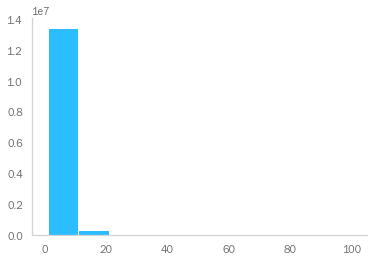

In [96]:
plt.hist(rec_df['count']);

In [5]:
# Well I'm not sure if this is the best way, but there are so few above 5 I think I can group them all together
rec_df['rating'] = rec_df['count'].apply(lambda x: 5 if (x >= 5) else x)

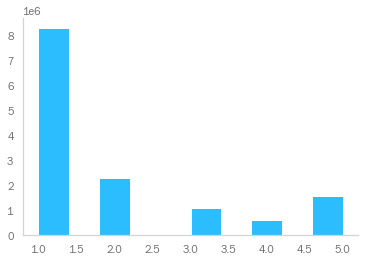

In [6]:
plt.hist(rec_df['rating']);

In [7]:
new_rec_df = rec_df.drop(columns='count')
new_rec_df.head()

,user_id,product_id,rating
0,1,196,5
1,1,12427,5
2,1,10258,5
3,1,25133,5
4,1,46149,4


In [9]:
# Must start with a new reader

tic = time.time()
reader = Reader(rating_scale=(1, 5))
readtime = time.time()-tic
print(readtime)
# The columns must correspond to user id, item id and ratings (in that order).
toc = time.time()
new_rec_data = Dataset.load_from_df(new_rec_df, reader)
loadtime = time.time()-toc
print(loadtime)
# sample random trainset and testset
# test set is made of 25% of the ratings.
tac = time.time()
new_trainset, new_testset = train_test_split(new_rec_data, test_size=.25, random_state=12)
splittime = time.time()-tac
print(splittime)

0.0
11.809852838516235
43.78789830207825


In [102]:
# Might as well start with the best params from the last model

'''tic = time.time()

new_svd_algo = SVD(n_factors = 100, n_epochs = 10, lr_all = 0.005, reg_all = 0.4)

new_svd_algo.fit(new_trainset)

fit_time = time.time()-tic
print('fit ', fit_time)
toc = time.time()

new_predictions = new_svd_algo.test(new_testset)

pred_time = time.time()-toc
print('pred ', pred_time)

# Then compute RMSE
accuracy.rmse(new_predictions)

# Not bad, RMSE went to to 1.2649'''

fit  288.56942772865295
pred  204.20226907730103
RMSE: 1.2649


1.2648735882122

In [103]:
# pickle.dump(new_svd_algo, open("Pickle/new_svd_algo.p", "wb"))

In [104]:
# pickle.dump(new_predictions, open("Pickle/new_predictions.p", "wb"))

In [8]:
new_svd_algo = pickle.load(open("Pickle/new_svd_algo.p", "rb"))

In [106]:
new_predictions = pickle.load(open("Pickle/new_predictions.p", "rb"))

In [107]:
accuracy.rmse(new_predictions)

RMSE: 1.2649


1.2648735882122

In [108]:
# This prediction was 1.76 before, it has gone up to 2.12 with the new scale

uid=196
iid=13176
# get a prediction for specific users and items.
pred = new_svd_algo.predict(uid, iid, r_ui=2, verbose=True)

user: 196        item: 13176      r_ui = 2.00   est = 2.12   {'was_impossible': False}


In [109]:
# This estimate was 1.498 before and now it is 1.475

new_predictions[0]

Prediction(uid=127895, iid=6101, r_ui=2.0, est=1.475188661747201, details={'was_impossible': False})

In [110]:
# this one was 100 on the last scale but predicted as 21.59
# now it is a 5 on the new scale and predicted at 3.21

pred = new_svd_algo.predict(41356,38652, r_ui=5.0, verbose=True)

user: 41356      item: 38652      r_ui = 5.00   est = 3.21   {'was_impossible': False}


In [11]:
# Well lets try another grid search

# Started at 9:57am, ended at 12:30pm

'''param_grid = {'n_factors':[20, 100],'n_epochs': [5, 10], 'lr_all': [0.002, 0.005],
              'reg_all': [0.4, 0.6]}
new_gs_model = GridSearchCV(SVD, param_grid=param_grid, n_jobs = -1, joblib_verbose=5)
new_gs_model.fit(new_rec_data)'''

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed: 76.9min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed: 133.1min finished


In [12]:
# pickle.dump(new_gs_model, open("Pickle/new_gs_model.p", "wb"))

In [13]:
new_gs_model = pickle.load(open("Pickle/new_gs_model.p", "rb"))

In [14]:
new_gs_model.best_params

{'rmse': {'n_factors': 20, 'n_epochs': 10, 'lr_all': 0.005, 'reg_all': 0.4},
 'mae': {'n_factors': 20, 'n_epochs': 10, 'lr_all': 0.005, 'reg_all': 0.4}}

In [15]:
new_results_df = pd.DataFrame.from_dict(new_gs_model.cv_results)

In [ ]:
new_results_df

In [17]:
# Creating the model from the best params

tic = time.time()

new_svd_best_gs = SVD(n_factors = 20, n_epochs = 10, lr_all = 0.005, reg_all = 0.4)

new_svd_best_gs.fit(new_trainset)

fit_time = time.time()-tic
print('fit ', fit_time)
toc = time.time()

new_svd_best_gs_predictions = new_svd_best_gs.test(new_testset)

pred_time = time.time()-toc
print('pred ', pred_time)

# Then compute RMSE
accuracy.rmse(new_svd_best_gs_predictions)

# RMSE went down on grid search model from 1.2649 to 1.2648.  lol, not much.

fit  135.78296637535095
pred  63.0951828956604
RMSE: 1.2648


1.2648270072757875

In [19]:
pickle.dump(new_svd_best_gs, open("Pickle/new_svd_best_gs.p", "wb"))

In [20]:
pickle.dump(new_svd_best_gs_predictions, open("Pickle/new_svd_best_gs_predictions.p", "wb"))

In [21]:
# new_svd_best_gs = pickle.load(open("Pickle/new_svd_best_gs.p", "rb"))

In [22]:
# new_svd_best_gs_predictions = pickle.load(open("Pickle/new_svd_best_gs_predictions.p", "rb"))

## Get top n predictions for a user

In [34]:
# Get top predictions for a user

from collections import defaultdict

def get_top_n(predictions, n=10):
    """Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    """

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n


# First train an SVD algorithm on the movielens dataset.
# data = Dataset.load_builtin('ml-100k')
# trainset = data.build_full_trainset()
# algo = SVD()
# algo.fit(trainset)

# Than predict ratings for all pairs (u, i) that are NOT in the training set.
anti_testset = new_trainset.build_anti_testset()
predictions = anti_new_svd_best_gs.test(anti_testset)

top_n = get_top_n(new_svd_best_gs_predictions, n=10)

# Print the recommended items for each user
# for uid, user_ratings in top_n.items():
#     print(uid, [iid for (iid, _) in user_ratings])

MemoryError: 

## Get recommendations for a new user

In [25]:
products_desc = pickle.load(open("Pickle/products_desc.p", "rb"))

In [26]:
def grocery_rater(df, num, aisle=None):
    userID = 300000
    rating_list = []
    while num > 0:
        if aisle:
            product = df[df['aisle'].str.contains(aisle)].sample(1)
        else:
            product = df.sample(1)
        print(product['product_name'].iloc[0])
        rating = input('How do you rate this product on a scale of 1-5, press n if you are unfamiliar:\n')
        if rating == 'n':
            continue
        else:
            rating_one_product = {'user_id':userID,'product_id':product['product_id'].iloc[0],'rating':rating}
            rating_list.append(rating_one_product) 
            num -= 1
    return rating_list  

In [27]:
# try out the new function here!
user_rating = grocery_rater(products_desc, 4, aisle='candy')

White with 30% Cacao Content Organic Chocolate
How do you rate this product on a scale of 1-5, press n if you are unfamiliar:
1
Truffles, Organic, Hippie Hemp
How do you rate this product on a scale of 1-5, press n if you are unfamiliar:
3
Milk Chocolate with Butter Biscuit
How do you rate this product on a scale of 1-5, press n if you are unfamiliar:
n
Take 5 Snack Size Candy
How do you rate this product on a scale of 1-5, press n if you are unfamiliar:
4
Assorted Chocolate Miniatures Chocolate Candy Bars
How do you rate this product on a scale of 1-5, press n if you are unfamiliar:
5


In [28]:
user_rating

[{'user_id': 300000, 'product_id': 17281, 'rating': '1'},
 {'user_id': 300000, 'product_id': 38466, 'rating': '3'},
 {'user_id': 300000, 'product_id': 30740, 'rating': '4'},
 {'user_id': 300000, 'product_id': 42535, 'rating': '5'}]

In [29]:
## add the new ratings to the original ratings DataFrame
new_ratings_df = new_rec_df.append(user_rating, ignore_index=True)
new_data = Dataset.load_from_df(new_ratings_df, reader)

In [30]:
# train a model using the new combined DataFrame
new_user_svd = SVD(n_factors = 20, n_epochs = 10, lr_all = 0.005, reg_all = 0.4)
new_user_svd.fit(new_data.build_full_trainset())

In [31]:
# make predictions for the user

list_of_products = []
for product in new_ratings_df['product_id'].unique():
    product_name = products_desc[products_desc['product_id'] == product]['product_name'].iloc[0]
    product_aisle = products_desc[products_desc['product_id'] == product]['aisle'].iloc[0]
    list_of_products.append((product, new_user_svd.predict(300000, product)[3], product_name, product_aisle))

In [32]:
# order the predictions from highest to lowest rated

ranked_products = sorted(list_of_products, key=lambda x:x[1], reverse=True)

In [33]:
# return the top n recommendations using the 
def recommended_products(ranked_products, n, aisle=None):
        for idx, rec in enumerate(ranked_products):
            if aisle:    
                if aisle in rec[3]:
                    name = rec[2]
                    print('Recommendation # ', idx+1, ': ', name, '\n')
                    n-= 1
                elif idx == len(ranked_products)-1:
                    print('No recommended products found')
                    continue
            else:
                name = rec[2]
                print('Recommendation # ', idx+1, ': ', name, '\n')
                n-= 1
            if n == 0:
                break
            
recommended_products(ranked_products, 5, aisle='chocolate')

Recommendation #  223 :  Fine Artisan Chocolate Extra Rich Milk 41% Cacao 

Recommendation #  242 :  Maca Buttercups 

Recommendation #  271 :  Milk Chocolate Almonds 

Recommendation #  674 :  Peanut Milk Chocolate XXL Bag 

Recommendation #  695 :  Olive Oil Sea Salt Bar 



In [ ]:
algo.trainset.knows_user(1)
True
algo.trainset.knows_item(0)
True
algo.predict('1','0',4)
Prediction(uid='1', iid='0', r_ui=4, est=3.5444502774861255, details={u'reason': '', u'was_impossible': True})

Actually you can use algo.test(), which works on large number of records. This is what I do:

test.loc[:, 'rating'] = 0 # fill in a dummy rating column since it is required in step 2
test_processed = Dataset.load_from_df(test[['user_id','book_id','rating']], reader) # use load_from_df to convert the test dataframe to the Dataset format required by step 3
NA, test = train_test_split(test_processed, test_size=1.0) # use train_test_split to convert test_processed to list of tuples required in step 4
predictions = algo.test(test)
est = [i.est for i in predictions] # retrieve the est from prediction results.
I used this method to predict on 7M records and it takes about 10 mins on my Macbook Pro.

to_inner_uid(), to_inner_iid(), to_raw_uid(), and to_raw_iid() methods of the trainset

## Prepare Data for Market Basket Analysis

## Market Basket Analysis

In [ ]:
pip install efficient-apriori

In [ ]:
from efficient_apriori import apriori

In [ ]:
transactions = [('eggs', 'bacon', 'soup'),
                ('eggs', 'bacon', 'apple'),
                ('soup', 'bacon', 'banana')]
itemsets, rules = apriori(transactions, min_support=0.5, min_confidence=1)
print(rules)  # [{eggs} -> {bacon}, {soup} -> {bacon}]

In [ ]:
transactions = [('eggs', 'bacon', 'soup'),
                ('eggs', 'bacon', 'apple'),
                ('soup', 'bacon', 'banana')]
itemsets, rules = apriori(transactions, min_support=0.2, min_confidence=1)

# Print out every rule with 2 items on the left hand side,
# 1 item on the right hand side, sorted by lift
rules_rhs = filter(lambda rule: len(rule.lhs) == 2 and len(rule.rhs) == 1, rules)
for rule in sorted(rules_rhs, key=lambda rule: rule.lift):
  print(rule)  # Prints the rule and its confidence, support, lift, ...

In [ ]:
transactions = [('eggs', 'bacon', 'soup'),
                ('eggs', 'bacon', 'apple'),
                ('soup', 'bacon', 'banana')]
itemsets, rules = apriori(transactions, output_transaction_ids=True)
print(itemsets)
# {1: {('bacon',): ItemsetCount(itemset_count=3, members={0, 1, 2}), ...

## Interpret Results / Conclusions

In [ ]:
pd.DataFrame([Philly_metrics, Indy_metrics, Daytona_metrics, Columbus_metrics, KC_metrics, Chattanooga_metrics])

In [ ]:
def final_ROI(dfs, forecasts):
    comparison = pd.DataFrame(index=['Zip Code','median housing price','actual 2018 ROI', 'forecast 2018 ROI'])
    for i, df in enumerate(dfs):
        metrics = [df['RegionName'][0], df.iloc[0,-1], round(100*df['recent_1_yr_ROI'][0],2), 
                   round(100*calc_forecast_ROI(forecasts[i]),2)]
        comparison[df['City'][0]] = metrics        
    return comparison

ROI_comparison = final_ROI(original_dfs, forecast_dfs)
ROI_comparison

Results: 

* Cluster data is fabulous for market segmentation and targeted marketing
* 
* All training data outperformed the test data.
* The models are all very skewed because of the market crash in 2009.
* Columbus and Daytona had very large confidence intervals and overly high forecasts.
* Chattanooga has outperformed even the confidence intervals of the model.
* Philadelphia is potentially a good 50K investment , Indianapolis at 75K and Chattanooga at 100K investment

Caveats: 
* Logged and differenced the data but some still did not test as stationary according to the Dickey Fuller test.
* Real estate predictions can vary due to unseen fluctuations in the market

Next Steps/Future Work: 

* Go back and cluster again allowing more than 20 clusters to make some of the big clusters smaller?  
* Cluster by what portion of each order was from each aisle rather than number of items?  
* Analyze which clusters buy the most products **per person**  


## Move data in SQL tables (on AWS?)

In [69]:
# from sqlalchemy import create_engine

# engine = create_engine('sqlite:///grocery.db', echo=True)

In [70]:
# user_data.to_sql('users', con=engine, if_exists='replace')

2021-02-09 17:58:13,407 INFO sqlalchemy.engine.base.Engine SELECT CAST('test plain returns' AS VARCHAR(60)) AS anon_1
2021-02-09 17:58:13,410 INFO sqlalchemy.engine.base.Engine ()
2021-02-09 17:58:13,411 INFO sqlalchemy.engine.base.Engine SELECT CAST('test unicode returns' AS VARCHAR(60)) AS anon_1
2021-02-09 17:58:13,412 INFO sqlalchemy.engine.base.Engine ()
2021-02-09 17:58:13,415 INFO sqlalchemy.engine.base.Engine PRAGMA main.table_info("users")
2021-02-09 17:58:13,416 INFO sqlalchemy.engine.base.Engine ()
2021-02-09 17:58:13,422 INFO sqlalchemy.engine.base.Engine PRAGMA main.table_info("users")
2021-02-09 17:58:13,423 INFO sqlalchemy.engine.base.Engine ()
2021-02-09 17:58:13,425 INFO sqlalchemy.engine.base.Engine SELECT name FROM sqlite_master WHERE type='table' ORDER BY name
2021-02-09 17:58:13,426 INFO sqlalchemy.engine.base.Engine ()
2021-02-09 17:58:13,428 INFO sqlalchemy.engine.base.Engine PRAGMA main.table_xinfo("users")
2021-02-09 17:58:13,428 INFO sqlalchemy.engine.base.Eng

MemoryError: Unable to allocate 258. MiB for an array with shape (33819106,) and data type object

In [ ]:
# result = engine.execute('SELECT * from users;')
# pd.DataFrame(result.fetchall(), columns = result.keys())